In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('./energy_demand_hourly_brazil.csv')
df.index = df['index']
df.drop(columns='index', axis=1, inplace=True)

In [ ]:
df.index = pd.to_datetime(df.index)
df

,hourly_demand
index,
2000-01-01 00:00:00,34673.900
2000-01-01 01:00:00,33503.000
2000-01-01 02:00:00,32287.600
2000-01-01 03:00:00,31059.400
2000-01-01 04:00:00,30272.700
...,...
2022-12-31 20:00:00,75825.344
2022-12-31 21:00:00,69894.955
2022-12-31 22:00:00,64612.355


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201318 entries, 2000-01-01 00:00:00 to 2023-01-01 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   hourly_demand  201318 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB


In [ ]:
def new_columns(dataframe):
  dataframe['hour'] = dataframe.index.hour
  dataframe['dayofweek'] = dataframe.index.dayofweek
  dataframe['quarter'] = dataframe.index.quarter
  dataframe['month'] = dataframe.index.month
  dataframe['year'] = dataframe.index.year
  dataframe['dayofyear'] = dataframe.index.dayofyear
  dataframe['hourly_demand'] = round(dataframe['hourly_demand'],0)
  return dataframe

In [ ]:
df = new_columns(df)
df.sample(5)

,hourly_demand,hour,dayofweek,quarter,month,year,dayofyear
index,,,,,,,
2000-03-21 09:00:00,43913.0,9,1,1,3,2000,81
2012-06-04 03:00:00,40701.0,3,0,2,6,2012,156
2006-05-16 10:00:00,51390.0,10,1,2,5,2006,136
2022-12-26 13:00:00,64785.0,13,0,4,12,2022,360
2007-08-10 22:00:00,54367.0,22,4,3,8,2007,222


In [ ]:
df = df[df['hourly_demand'] > 2000]

<AxesSubplot:xlabel='index', ylabel='hourly_demand'>

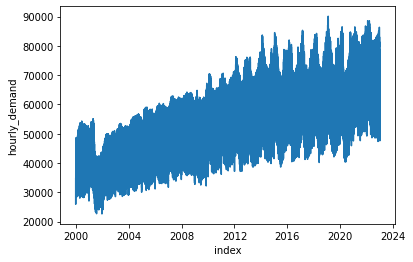

In [ ]:
sns.lineplot(data=df,x=df.index,y='hourly_demand')

In [ ]:
treino = df[df['year'] <= 2018]
teste = df[df['year'] > 2018]


treino_x = df[df['year'] <= 2018].drop(columns='hourly_demand', axis=1)
treino_y = df[df['year'] <= 2018]['hourly_demand']
teste_x = df[df['year'] > 2018].drop(columns='hourly_demand', axis=1)
teste_y = df[df['year'] > 2018]['hourly_demand']


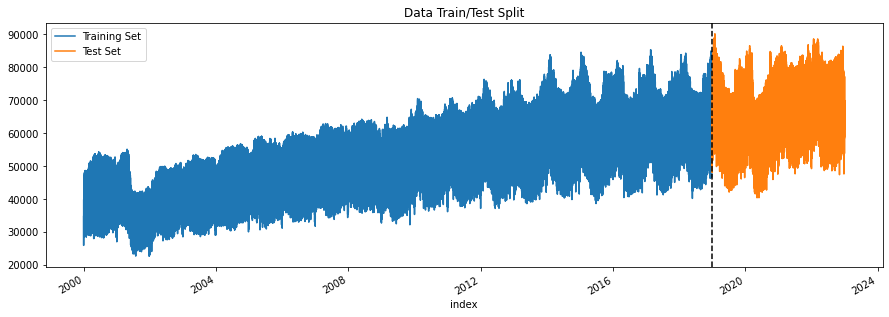

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
treino['hourly_demand'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
teste['hourly_demand'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=100,
                       early_stopping_rounds=50,
                       objective='reg:linear')

b = reg.fit(treino_x,treino_y,eval_set=[(treino_x, treino_y), (teste_x, teste_y)],
        verbose=100)


[01:47:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:37261.36710	validation_1-rmse:48258.01262
[99]	validation_0-rmse:1358.64358	validation_1-rmse:5464.35407


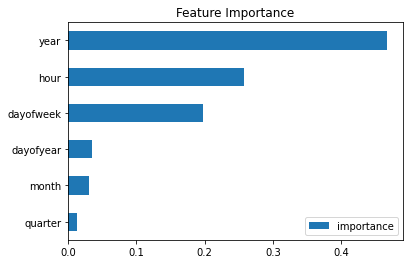

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<ipython-input-92-6ac6849d5cd4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['predict'] = reg.predict(teste_x)


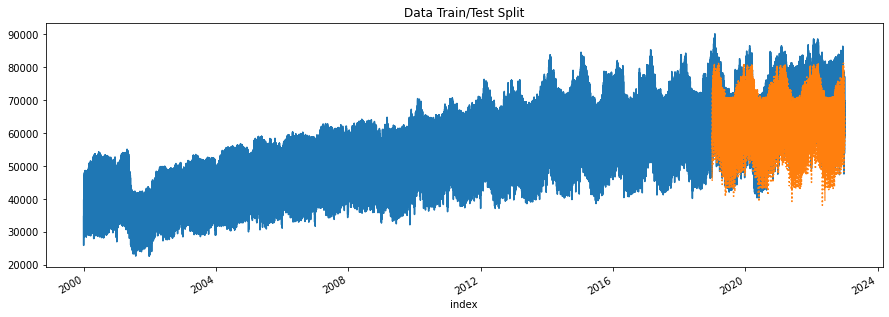

In [ ]:
teste['predict'] = reg.predict(teste_x)
fig, ax = plt.subplots(figsize=(15, 5))
df['hourly_demand'].plot(ax=ax,label='normal')
teste['predict'].plot(ax=ax,label='Predict',ls='dotted' ,title='Data Train/Test Split')
plt.show()


